## Машинное обучение в бизнесе
### Итоговый проект

In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from app.conf.dicts import CATEGORICAL_FEATURES_MAPS
pd.options.mode.chained_assignment = None

In [4]:
# https://archive.ics.uci.edu/dataset/222/bank+marketing
dataset = pd.read_csv('./bank.csv', delimiter=';')
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
TARGET = 'y'

In [6]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [7]:
dataset['y'] = dataset['y'].map({'no':0, 'yes': 1})
dataset['y'] = dataset['y'].astype(int)

In [8]:
categorical_columns = [col for col in dataset.columns if dataset[col].dtype=="O"]
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

<AxesSubplot:>

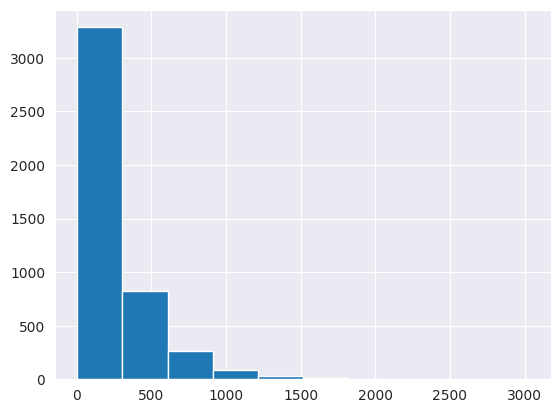

In [9]:
dataset['duration'].hist()

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511,0.045092
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196,0.017905
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114,-0.011244
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080,0.401118
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833,-0.061147
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562,0.104087
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000,0.116714
y,0.045092,0.017905,-0.011244,0.401118,-0.061147,0.104087,0.116714,1.000000


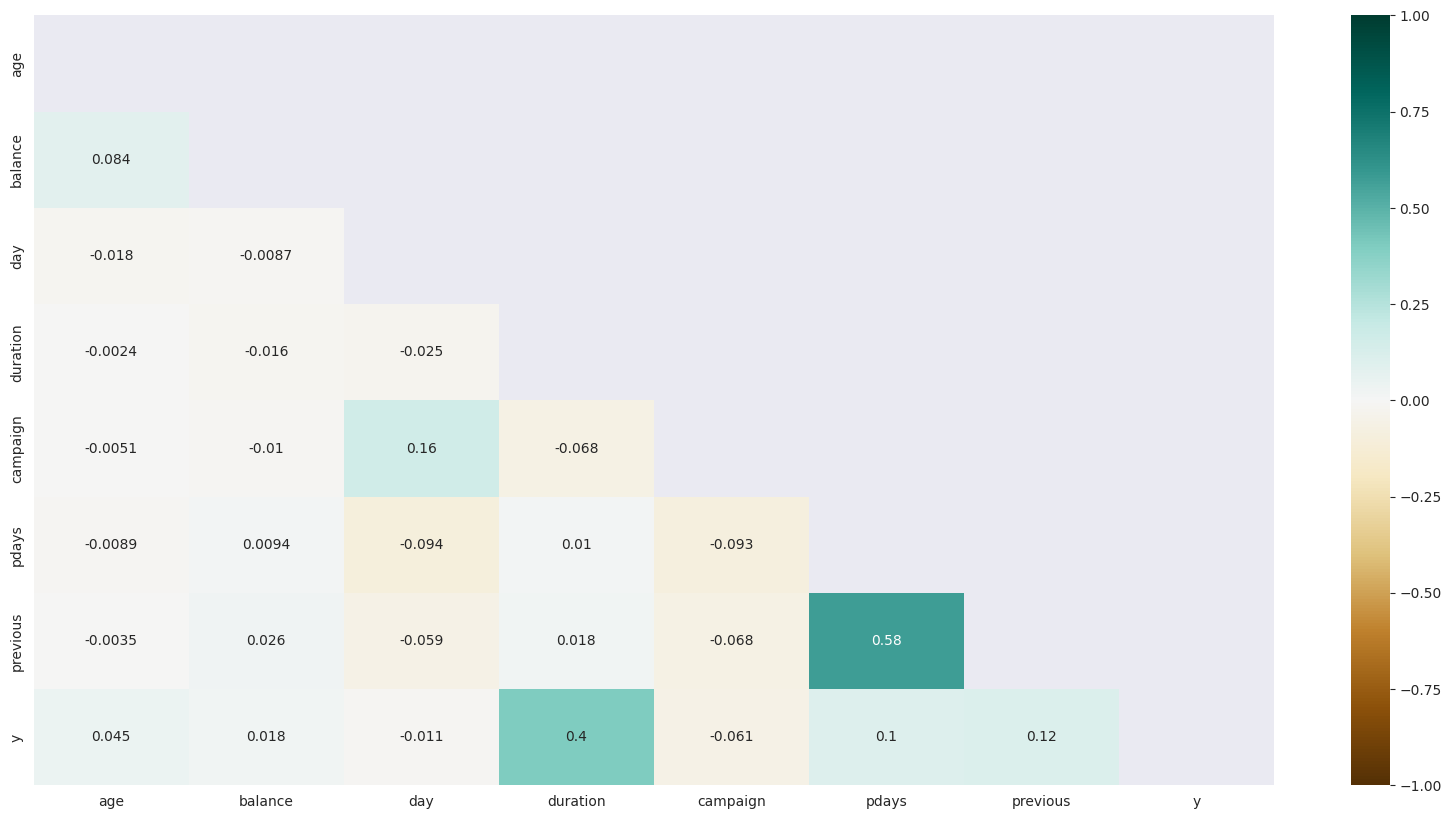

In [10]:
plt.figure(figsize=(20,10))
c= dataset.corr()
cor_matrix_mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c,cmap="BrBG",annot=True, vmin=-1, vmax=1, mask=cor_matrix_mask)
c

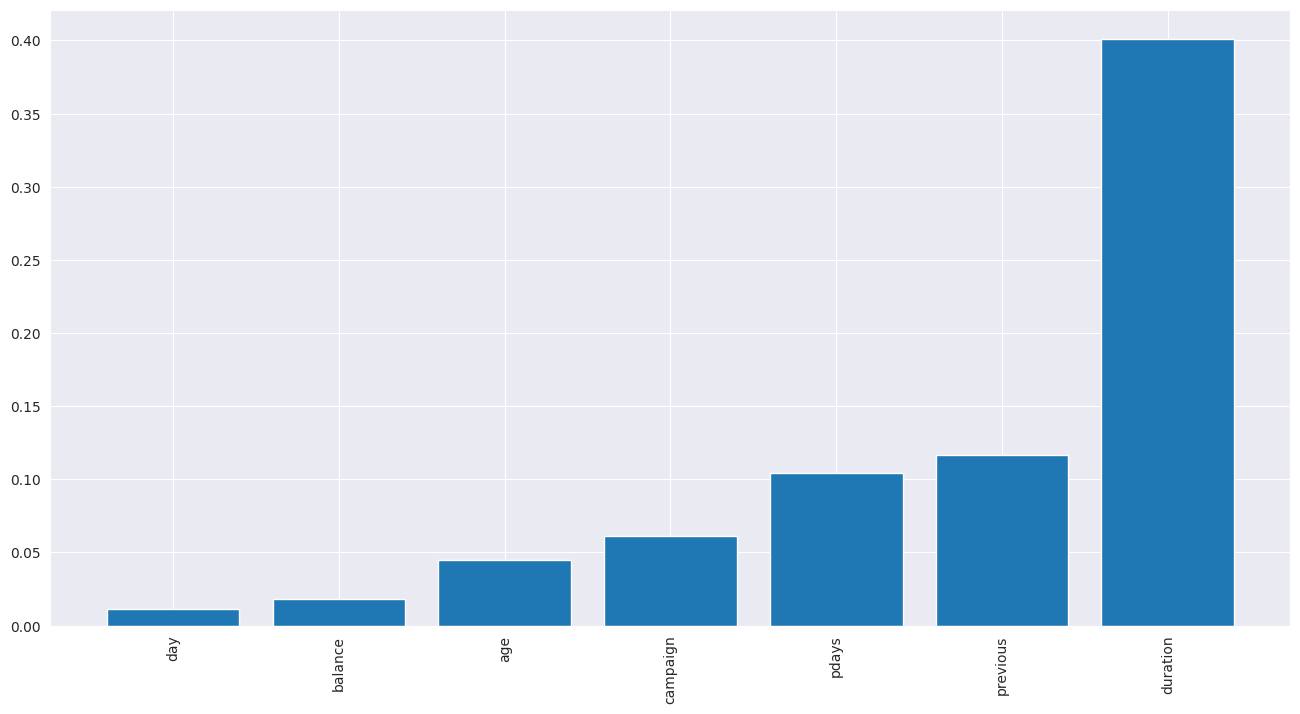

In [11]:
price_corr = dataset.corr().abs()
price_corr = price_corr.unstack().sort_values()['y']

plt.figure(figsize = (16, 8))
plt.bar(list(price_corr.keys())[:-1], list(price_corr)[:-1])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

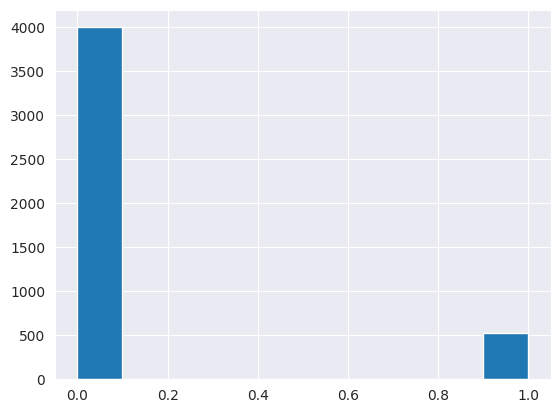

In [12]:
# балансировка классов
dataset[TARGET].hist()

In [13]:
rat = len(dataset.loc[dataset[TARGET]==0])//len(dataset.loc[dataset[TARGET]==1])
ds_1 = dataset.loc[dataset[TARGET]==1]
ds_1 = ds_1.loc[ds_1.index.repeat(rat)]
dataset_normalize = pd.concat([dataset.loc[dataset[TARGET]==0], ds_1]).sample(frac=1)

<AxesSubplot:>

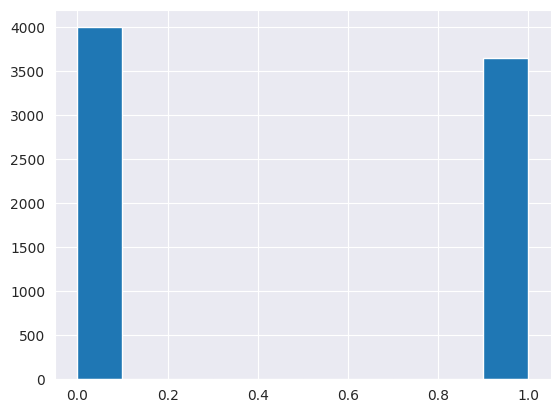

In [14]:
dataset_normalize[TARGET].hist()

In [27]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

class CategoryTransform(BaseEstimator, TransformerMixin):
    def __init__(self, map):
        self.map = map

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for _ in self.map.keys():
            X[_] = X[_].map(self.map[_])
        return X

In [49]:
other_cols = dataset_normalize.columns.difference(categorical_columns).difference(['balance','duration','y'])
other_cols

Index(['age', 'campaign', 'day', 'pdays', 'previous'], dtype='object')

In [50]:

transformers = list()
transformers.append(('cats', Pipeline([
    ('selector', ColumnSelector(columns=categorical_columns)),
    ('scaler', CategoryTransform(map=CATEGORICAL_FEATURES_MAPS)),
])))

transformers.append(('num', Pipeline([
    ('selector', ColumnSelector(columns=['balance','duration'])),
    ('scaler', preprocessing.MinMaxScaler())
])))

transformers.append(('other', Pipeline([
    ('selector', ColumnSelector(columns=other_cols)),
])))


In [51]:
feats = FeatureUnion(transformers)
feats

FeatureUnion(transformer_list=[('cats',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(columns=['job',
                                                                         'marital',
                                                                         'education',
                                                                         'default',
                                                                         'housing',
                                                                         'loan',
                                                                         'contact',
                                                                         'month',
                                                                         'poutcome'])),
                                                ('scaler',
                                                 CategoryTransform(map={'contact': {'cellular': 1,
                                                                                    'telephone': 2,
                                                                                    'unknown': 0},
                                                                        'default': {'no': 0,
                                                                                    'yes': 1},
                                                                        'education': {'primary': 1,
                                                                                      'secondary': 2,
                                                                                      'tertiary': 3,
                                                                                      'unknown'...
                                                                                  'mar': 3,
                                                                                  'may': 5,
                                                                                  'nov': 11,
                                                                                  'oct': 10,
                                                                                  'sep': 9},
                                                                        'poutcome': {'failure': -1,
                                                                                     'other': 0,
                                                                                     'success': 1,
                                                                                     'unknown': 0}}))])),
                               ('num',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(columns=['balance',
                                                                         'duration'])),
                                                ('scaler', MinMaxScaler())])),
                               ('other',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(columns=Index(['age', 'campaign', 'day', 'pdays', 'previous'], dtype='object')))]))])

In [55]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(dataset_normalize.drop(TARGET, axis=1), dataset_normalize[TARGET], test_size=0.2, random_state=41)

In [67]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)[:, 1]
y_pred = list(map(round, y_pred))

In [68]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       798
           1       0.94      1.00      0.97       732

    accuracy                           0.97      1530
   macro avg       0.97      0.97      0.97      1530
weighted avg       0.97      0.97      0.97      1530



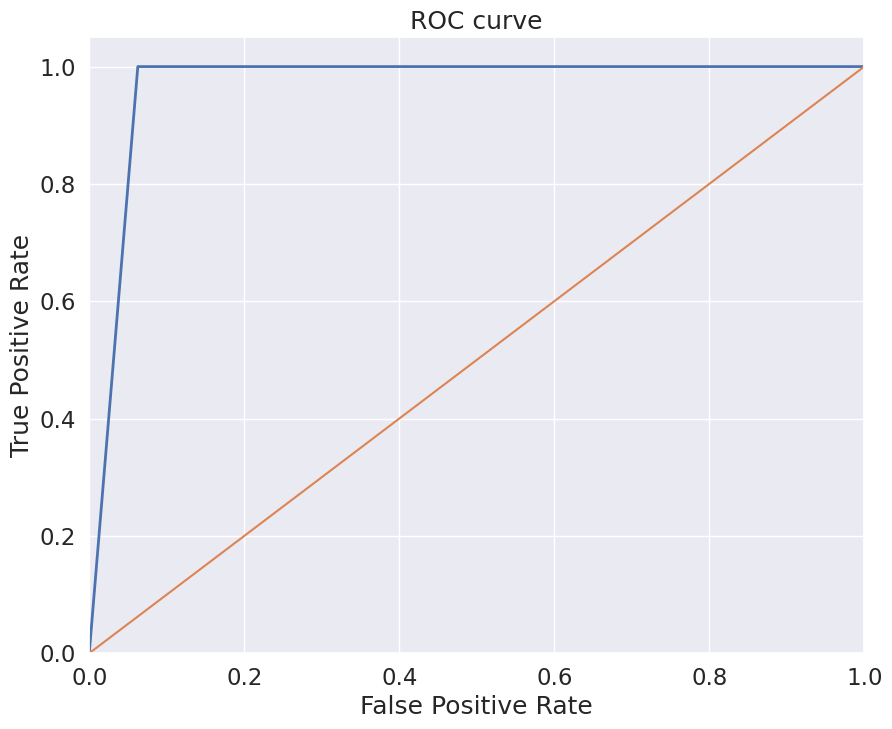

In [70]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.nanargmax(fscore)

roc_auc_score_ = metrics.roc_auc_score(y_test, y_pred)

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = metrics.roc_curve(y_test, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()